# PreTrain

In [1]:
from model.sswae_dev2_1 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 2

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [26]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [27]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [39]:
epoch = 5
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 0.010
[2] loss: 0.013
[3] loss: 0.008
[4] loss: 0.007
[5] loss: 0.013


In [34]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 2])

In [40]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

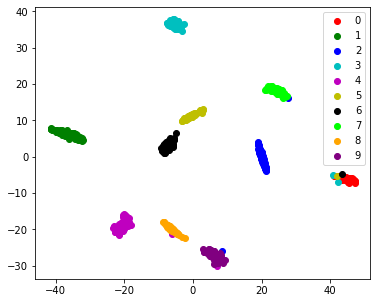

In [41]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

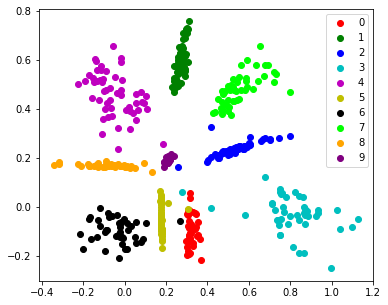

In [42]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)
covs = np.zeros((10, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.0703,  0.2800, -0.0915,  0.0476,  0.0056, -0.1022, -0.1094,  0.2350,
         -0.1177,  0.0753],
        [ 0.3326,  0.0934,  0.0625,  0.2343,  0.0451, -0.0811, -0.0573,  0.2351,
         -0.1030, -0.0567]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)

In [15]:
for i in range(10):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10, 1, y_dim, bias=False)
f2.weight.data = w2.view(10,1,y_dim,y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}.pt')

# Train

In [3]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1_8.cfg')

['./config/sswae_dev2_1_8.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}.pt'))

mm.train()
#mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 8
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 2
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.241676e-01  D: 6.921934e-01  D2: 4.974731e-03  D3: 3.803740e-03
test loss: 1.716113e-01  D: 7.154130e-01  D2: -4.399347e-03  D3: 5.689981e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.630008e-01  D: 6.956959e-01  D2: -4.475058e-03  D3: 5.546326e-03
test loss: 1.930724e-01  D: 6.665709e-01  D2: -4.572821e-03  D3: 1.433050e-02


[default |INFO|model.py:1280] [03/80]  loss: 1.466762e-01  D: 6.936571e-01  D2: -4.754372e-03  D3: 5.660640e-03
test loss: 1.336818e-01  D: 6.856811e-01  D2: -4.953098e-03  D3: 5.202895e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.329653e-01  D: 6.949328e-01  D2: -4.840239e-03  D3: 5.560337e-03
test loss: 1.215768e-01  D: 7.232549e-01  D2: -3.758087e-03  D3: 4.757277e-03


[default |INFO|model.py:1280] [05/80]  loss: 1.087074e-01  D: 6.927085e-01  D2: -4.802343e-03  D3: 4.219333e-03
test loss: 1.064140e-01  D: 7.370492e-01  D2: -5.467472e-03  D3: 6.326217e-03


[default |INFO|model.py:1280] [06/80]  loss: 1.119732e-01  D: 6.968344e-01  D2: -4.496857e-03  D3: 8.571271e-03
test loss: 1.101098e-01  D: 7.215267e-01  D2: -4.782963e-03  D3: 1.293520e-02


[default |INFO|model.py:1280] [07/80]  loss: 1.250675e-01  D: 7.006959e-01  D2: -4.207770e-03  D3: 1.510386e-02
test loss: 1.073908e-01  D: 6.813348e-01  D2: -4.813414e-03  D3: 1.374324e-02


[default |INFO|model.py:1280] [08/80]  loss: 1.029254e-01  D: 6.944362e-01  D2: -4.826601e-03  D3: 1.470841e-02
test loss: 9.505172e-02  D: 6.784411e-01  D2: -5.267668e-03  D3: 1.488929e-02


[default |INFO|model.py:1280] [09/80]  loss: 9.132473e-02  D: 6.945263e-01  D2: -4.949894e-03  D3: 1.364116e-02
test loss: 9.192794e-02  D: 7.030681e-01  D2: -5.812407e-03  D3: 1.345016e-02


[default |INFO|model.py:1280] [10/80]  loss: 8.764367e-02  D: 6.931522e-01  D2: -4.943943e-03  D3: 1.492456e-02
test loss: 8.419610e-02  D: 7.292874e-01  D2: -5.399666e-03  D3: 1.468844e-02


[default |INFO|model.py:1280] [11/80]  loss: 8.321508e-02  D: 6.934290e-01  D2: -4.874911e-03  D3: 1.418296e-02
test loss: 7.928732e-02  D: 7.076880e-01  D2: -5.809469e-03  D3: 1.440028e-02


[default |INFO|model.py:1280] [12/80]  loss: 8.058934e-02  D: 6.943133e-01  D2: -5.295208e-03  D3: 1.419638e-02
test loss: 7.894393e-02  D: 6.811494e-01  D2: -5.265617e-03  D3: 1.258239e-02


[default |INFO|model.py:1280] [13/80]  loss: 7.995786e-02  D: 6.942742e-01  D2: -5.463195e-03  D3: 1.311019e-02
test loss: 8.122169e-02  D: 7.003616e-01  D2: -5.938282e-03  D3: 1.181666e-02


[default |INFO|model.py:1280] [14/80]  loss: 7.762464e-02  D: 6.946566e-01  D2: -5.220270e-03  D3: 1.376619e-02
test loss: 7.626315e-02  D: 6.964406e-01  D2: -6.277180e-03  D3: 1.497629e-02


[default |INFO|model.py:1280] [15/80]  loss: 7.560527e-02  D: 6.942410e-01  D2: -5.587715e-03  D3: 1.281721e-02
test loss: 7.385035e-02  D: 6.971808e-01  D2: -4.841824e-03  D3: 1.645736e-02


[default |INFO|model.py:1280] [16/80]  loss: 7.527447e-02  D: 6.927571e-01  D2: -5.521866e-03  D3: 1.310919e-02
test loss: 7.113297e-02  D: 6.907744e-01  D2: -6.003637e-03  D3: 1.358577e-02


[default |INFO|model.py:1280] [17/80]  loss: 7.357932e-02  D: 6.944467e-01  D2: -5.657220e-03  D3: 1.245479e-02
test loss: 7.010666e-02  D: 6.978801e-01  D2: -5.867720e-03  D3: 1.142790e-02


[default |INFO|model.py:1280] [18/80]  loss: 6.975640e-02  D: 6.943941e-01  D2: -5.834274e-03  D3: 1.307611e-02
test loss: 6.552104e-02  D: 6.739661e-01  D2: -5.934134e-03  D3: 1.291572e-02


[default |INFO|model.py:1280] [19/80]  loss: 6.780744e-02  D: 6.944032e-01  D2: -6.128341e-03  D3: 1.314159e-02
test loss: 6.758903e-02  D: 6.813406e-01  D2: -5.934992e-03  D3: 1.237819e-02


[default |INFO|model.py:1280] [20/80]  loss: 6.726218e-02  D: 6.929883e-01  D2: -5.860300e-03  D3: 1.300348e-02
test loss: 6.854120e-02  D: 7.043827e-01  D2: -6.756029e-03  D3: 1.312236e-02


[default |INFO|model.py:1280] [21/80]  loss: 6.832634e-02  D: 6.939609e-01  D2: -5.944737e-03  D3: 1.296095e-02
test loss: 6.716743e-02  D: 6.831108e-01  D2: -6.238232e-03  D3: 1.166163e-02


[default |INFO|model.py:1280] [22/80]  loss: 6.714159e-02  D: 6.938720e-01  D2: -6.434244e-03  D3: 1.250005e-02
test loss: 6.805459e-02  D: 6.819243e-01  D2: -6.599684e-03  D3: 1.015131e-02


[default |INFO|model.py:1280] [23/80]  loss: 6.597768e-02  D: 6.934271e-01  D2: -6.357306e-03  D3: 1.270556e-02
test loss: 6.405089e-02  D: 6.895897e-01  D2: -6.991301e-03  D3: 1.210480e-02


[default |INFO|model.py:1280] [24/80]  loss: 6.548954e-02  D: 6.937054e-01  D2: -6.417077e-03  D3: 1.249500e-02
test loss: 6.588714e-02  D: 6.875720e-01  D2: -6.224499e-03  D3: 1.088860e-02


[default |INFO|model.py:1280] [25/80]  loss: 6.462945e-02  D: 6.932827e-01  D2: -6.437804e-03  D3: 1.252370e-02
test loss: 6.579474e-02  D: 6.907836e-01  D2: -6.618071e-03  D3: 1.338885e-02


[default |INFO|model.py:1280] [26/80]  loss: 6.470608e-02  D: 6.938987e-01  D2: -6.710107e-03  D3: 1.209857e-02
test loss: 6.564705e-02  D: 6.984071e-01  D2: -6.597500e-03  D3: 1.205953e-02


[default |INFO|model.py:1280] [27/80]  loss: 6.419090e-02  D: 6.934340e-01  D2: -6.649949e-03  D3: 1.223072e-02
test loss: 6.518147e-02  D: 6.874533e-01  D2: -7.162914e-03  D3: 1.027740e-02


[default |INFO|model.py:1280] [28/80]  loss: 6.389821e-02  D: 6.932971e-01  D2: -6.538281e-03  D3: 1.198149e-02
test loss: 6.251165e-02  D: 6.841088e-01  D2: -7.503862e-03  D3: 1.178435e-02


[default |INFO|model.py:1280] [29/80]  loss: 6.256809e-02  D: 6.935366e-01  D2: -6.836829e-03  D3: 1.206024e-02
test loss: 6.304759e-02  D: 6.939046e-01  D2: -6.930103e-03  D3: 1.219876e-02


[default |INFO|model.py:1280] [30/80]  loss: 6.206171e-02  D: 6.934082e-01  D2: -6.878195e-03  D3: 1.200886e-02
test loss: 6.241438e-02  D: 6.863127e-01  D2: -6.703272e-03  D3: 1.153473e-02


[default |INFO|model.py:1280] [31/80]  loss: 6.225766e-02  D: 6.933660e-01  D2: -6.959642e-03  D3: 1.176108e-02
test loss: 6.629372e-02  D: 6.904733e-01  D2: -6.990728e-03  D3: 1.034231e-02


[default |INFO|model.py:1280] [32/80]  loss: 6.161357e-02  D: 6.932240e-01  D2: -7.191849e-03  D3: 1.187696e-02
test loss: 6.406950e-02  D: 7.032224e-01  D2: -7.013502e-03  D3: 1.134554e-02


[default |INFO|model.py:1280] [33/80]  loss: 6.111997e-02  D: 6.938794e-01  D2: -7.129107e-03  D3: 1.163558e-02
test loss: 6.175888e-02  D: 6.948441e-01  D2: -7.361832e-03  D3: 1.104520e-02


[default |INFO|model.py:1280] [34/80]  loss: 6.029349e-02  D: 6.934655e-01  D2: -7.177744e-03  D3: 1.173415e-02
test loss: 6.121247e-02  D: 6.911860e-01  D2: -7.508144e-03  D3: 1.256919e-02


[default |INFO|model.py:1280] [35/80]  loss: 6.010824e-02  D: 6.934157e-01  D2: -7.304695e-03  D3: 1.167225e-02
test loss: 6.130292e-02  D: 6.973620e-01  D2: -7.553635e-03  D3: 1.008400e-02


[default |INFO|model.py:1280] [36/80]  loss: 6.000111e-02  D: 6.932142e-01  D2: -7.478293e-03  D3: 1.168656e-02
test loss: 6.088172e-02  D: 6.885029e-01  D2: -7.750244e-03  D3: 1.075993e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.983872e-02  D: 6.934085e-01  D2: -7.496576e-03  D3: 1.164568e-02
test loss: 6.091292e-02  D: 6.940740e-01  D2: -7.697525e-03  D3: 1.160431e-02


[default |INFO|model.py:1280] [38/80]  loss: 6.016310e-02  D: 6.935227e-01  D2: -7.528094e-03  D3: 1.150333e-02
test loss: 6.053982e-02  D: 6.959842e-01  D2: -7.660799e-03  D3: 1.195262e-02


[default |INFO|model.py:1280] [39/80]  loss: 5.930626e-02  D: 6.933065e-01  D2: -7.452807e-03  D3: 1.152623e-02
test loss: 5.933477e-02  D: 6.895895e-01  D2: -7.820187e-03  D3: 1.246310e-02


[default |INFO|model.py:1280] [40/80]  loss: 5.903500e-02  D: 6.938496e-01  D2: -7.572980e-03  D3: 1.140357e-02
test loss: 6.118274e-02  D: 6.880798e-01  D2: -7.686844e-03  D3: 1.267735e-02


[default |INFO|model.py:1280] [41/80]  loss: 5.859227e-02  D: 6.924540e-01  D2: -7.641810e-03  D3: 1.152806e-02
test loss: 6.125782e-02  D: 6.930772e-01  D2: -7.567940e-03  D3: 1.097595e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.874065e-02  D: 6.932304e-01  D2: -7.714025e-03  D3: 1.133884e-02
test loss: 6.033307e-02  D: 6.926533e-01  D2: -7.700043e-03  D3: 1.168927e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.831555e-02  D: 6.934049e-01  D2: -7.808577e-03  D3: 1.138116e-02
test loss: 6.014882e-02  D: 6.969933e-01  D2: -8.138285e-03  D3: 1.180267e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.852542e-02  D: 6.930936e-01  D2: -7.904123e-03  D3: 1.132655e-02
test loss: 6.056281e-02  D: 6.992407e-01  D2: -7.809401e-03  D3: 1.273498e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.840108e-02  D: 6.935546e-01  D2: -7.871520e-03  D3: 1.118529e-02
test loss: 5.926263e-02  D: 6.879192e-01  D2: -8.121729e-03  D3: 1.102769e-02


[default |INFO|model.py:1280] [46/80]  loss: 5.832210e-02  D: 6.934798e-01  D2: -7.955260e-03  D3: 1.125156e-02
test loss: 6.097481e-02  D: 6.897489e-01  D2: -7.841024e-03  D3: 1.024093e-02


[default |INFO|model.py:1280] [47/80]  loss: 5.827995e-02  D: 6.926723e-01  D2: -8.034798e-03  D3: 1.107194e-02
test loss: 6.150282e-02  D: 6.972018e-01  D2: -7.240038e-03  D3: 1.042862e-02


[default |INFO|model.py:1280] [48/80]  loss: 5.780951e-02  D: 6.934630e-01  D2: -8.054520e-03  D3: 1.108516e-02
test loss: 5.935306e-02  D: 6.921264e-01  D2: -8.389454e-03  D3: 1.081552e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.769474e-02  D: 6.931481e-01  D2: -8.090755e-03  D3: 1.096353e-02
test loss: 5.819268e-02  D: 7.018017e-01  D2: -8.250647e-03  D3: 1.031294e-02


[default |INFO|model.py:1280] [50/80]  loss: 5.764343e-02  D: 6.933598e-01  D2: -8.067656e-03  D3: 1.118376e-02
test loss: 6.161485e-02  D: 6.962490e-01  D2: -8.093662e-03  D3: 1.075486e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.766418e-02  D: 6.928410e-01  D2: -8.202772e-03  D3: 1.093241e-02
test loss: 6.131014e-02  D: 6.875426e-01  D2: -8.397236e-03  D3: 1.027103e-02


[default |INFO|model.py:1280] [52/80]  loss: 5.761151e-02  D: 6.930923e-01  D2: -8.164953e-03  D3: 1.102957e-02
test loss: 6.010733e-02  D: 6.927374e-01  D2: -8.323336e-03  D3: 1.103795e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.711128e-02  D: 6.933163e-01  D2: -8.163675e-03  D3: 1.104605e-02
test loss: 5.902458e-02  D: 6.969916e-01  D2: -8.335981e-03  D3: 1.062539e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.716421e-02  D: 6.934436e-01  D2: -8.321449e-03  D3: 1.093143e-02
test loss: 6.157892e-02  D: 6.892263e-01  D2: -8.700991e-03  D3: 1.080308e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.680938e-02  D: 6.930104e-01  D2: -8.293544e-03  D3: 1.103643e-02
test loss: 6.033064e-02  D: 6.879141e-01  D2: -8.554115e-03  D3: 1.101765e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.657768e-02  D: 6.935812e-01  D2: -8.298550e-03  D3: 1.096742e-02
test loss: 5.857449e-02  D: 6.863836e-01  D2: -8.438225e-03  D3: 1.094097e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.630446e-02  D: 6.927594e-01  D2: -8.389562e-03  D3: 1.106039e-02
test loss: 5.854226e-02  D: 6.887753e-01  D2: -8.393602e-03  D3: 1.022914e-02


[default |INFO|model.py:1280] [58/80]  loss: 5.604659e-02  D: 6.935765e-01  D2: -8.409314e-03  D3: 1.094939e-02
test loss: 5.849304e-02  D: 6.895924e-01  D2: -8.466749e-03  D3: 1.209976e-02


[default |INFO|model.py:1280] [59/80]  loss: 5.577275e-02  D: 6.932402e-01  D2: -8.423381e-03  D3: 1.091145e-02
test loss: 5.909778e-02  D: 6.922141e-01  D2: -8.233690e-03  D3: 1.030371e-02


[default |INFO|model.py:1280] [60/80]  loss: 5.587668e-02  D: 6.935250e-01  D2: -8.454680e-03  D3: 1.088994e-02
test loss: 5.915664e-02  D: 6.952807e-01  D2: -8.065815e-03  D3: 1.129316e-02


[default |INFO|model.py:1280] [61/80]  loss: 5.548878e-02  D: 6.932473e-01  D2: -8.440758e-03  D3: 1.092967e-02
test loss: 5.896180e-02  D: 6.990068e-01  D2: -8.293371e-03  D3: 9.768882e-03


[default |INFO|model.py:1280] [62/80]  loss: 5.544183e-02  D: 6.932534e-01  D2: -8.467541e-03  D3: 1.077459e-02
test loss: 5.998934e-02  D: 6.959608e-01  D2: -8.272429e-03  D3: 1.127305e-02


[default |INFO|model.py:1280] [63/80]  loss: 5.512608e-02  D: 6.933452e-01  D2: -8.476636e-03  D3: 1.086377e-02
test loss: 5.764627e-02  D: 6.946362e-01  D2: -8.675451e-03  D3: 1.145084e-02


[default |INFO|model.py:1280] [64/80]  loss: 5.540582e-02  D: 6.933748e-01  D2: -8.500115e-03  D3: 1.085959e-02
test loss: 5.778241e-02  D: 6.904843e-01  D2: -8.464928e-03  D3: 1.040813e-02


[default |INFO|model.py:1280] [65/80]  loss: 5.443342e-02  D: 6.932458e-01  D2: -8.570620e-03  D3: 1.082644e-02
test loss: 5.753099e-02  D: 6.949387e-01  D2: -8.643713e-03  D3: 1.120551e-02


[default |INFO|model.py:1280] [66/80]  loss: 5.462768e-02  D: 6.931467e-01  D2: -8.538715e-03  D3: 1.093874e-02
test loss: 5.803141e-02  D: 6.971325e-01  D2: -8.601170e-03  D3: 1.078618e-02


[default |INFO|model.py:1280] [67/80]  loss: 5.449532e-02  D: 6.932092e-01  D2: -8.598658e-03  D3: 1.084556e-02
test loss: 5.785531e-02  D: 6.983402e-01  D2: -8.668804e-03  D3: 1.056197e-02


[default |INFO|model.py:1280] [68/80]  loss: 5.422127e-02  D: 6.932552e-01  D2: -8.547242e-03  D3: 1.078256e-02
test loss: 5.702920e-02  D: 6.926116e-01  D2: -8.383055e-03  D3: 1.007403e-02


[default |INFO|model.py:1280] [69/80]  loss: 5.470408e-02  D: 6.935936e-01  D2: -8.563987e-03  D3: 1.085140e-02
test loss: 5.690093e-02  D: 6.984467e-01  D2: -8.801775e-03  D3: 1.061105e-02


[default |INFO|model.py:1280] [70/80]  loss: 5.446128e-02  D: 6.930796e-01  D2: -8.596059e-03  D3: 1.080775e-02
test loss: 5.859023e-02  D: 6.968003e-01  D2: -8.514814e-03  D3: 1.045144e-02


[default |INFO|model.py:1280] [71/80]  loss: 5.392372e-02  D: 6.933695e-01  D2: -8.609689e-03  D3: 1.067621e-02
test loss: 5.781385e-02  D: 6.938708e-01  D2: -8.608456e-03  D3: 9.574078e-03


[default |INFO|model.py:1280] [72/80]  loss: 5.381277e-02  D: 6.932365e-01  D2: -8.646348e-03  D3: 1.073158e-02
test loss: 5.692867e-02  D: 6.963175e-01  D2: -8.737421e-03  D3: 1.108652e-02


[default |INFO|model.py:1280] [73/80]  loss: 5.368428e-02  D: 6.935109e-01  D2: -8.639855e-03  D3: 1.067745e-02
test loss: 5.716775e-02  D: 6.960929e-01  D2: -8.833551e-03  D3: 1.043798e-02


[default |INFO|model.py:1280] [74/80]  loss: 5.348502e-02  D: 6.933113e-01  D2: -8.713544e-03  D3: 1.063014e-02
test loss: 5.664064e-02  D: 6.890883e-01  D2: -8.393393e-03  D3: 1.031569e-02


[default |INFO|model.py:1280] [75/80]  loss: 5.368571e-02  D: 6.930837e-01  D2: -8.674723e-03  D3: 1.077268e-02
test loss: 5.647274e-02  D: 6.968075e-01  D2: -8.941717e-03  D3: 1.152739e-02


[default |INFO|model.py:1280] [76/80]  loss: 5.371022e-02  D: 6.933224e-01  D2: -8.619709e-03  D3: 1.069425e-02
test loss: 5.790072e-02  D: 6.916797e-01  D2: -8.751059e-03  D3: 1.042323e-02


[default |INFO|model.py:1280] [77/80]  loss: 5.377527e-02  D: 6.932040e-01  D2: -8.721940e-03  D3: 1.073949e-02
test loss: 5.672247e-02  D: 6.912690e-01  D2: -8.836689e-03  D3: 1.131264e-02


[default |INFO|model.py:1280] [78/80]  loss: 5.368954e-02  D: 6.932806e-01  D2: -8.722822e-03  D3: 1.066323e-02
test loss: 5.756527e-02  D: 6.884776e-01  D2: -8.812141e-03  D3: 1.111043e-02


[default |INFO|model.py:1280] [79/80]  loss: 5.352674e-02  D: 6.933781e-01  D2: -8.741287e-03  D3: 1.063519e-02
test loss: 5.685932e-02  D: 6.939133e-01  D2: -8.600941e-03  D3: 1.069662e-02


[default |INFO|model.py:1280] [80/80]  loss: 5.348122e-02  D: 6.932712e-01  D2: -8.651001e-03  D3: 1.063615e-02
test loss: 5.647296e-02  D: 6.942760e-01  D2: -8.659163e-03  D3: 1.088403e-02


[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3089.366s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

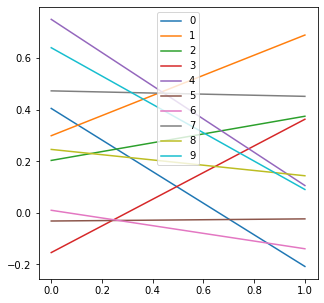

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

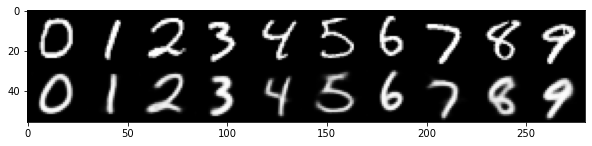

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
from XAE.sampler import gaus

exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

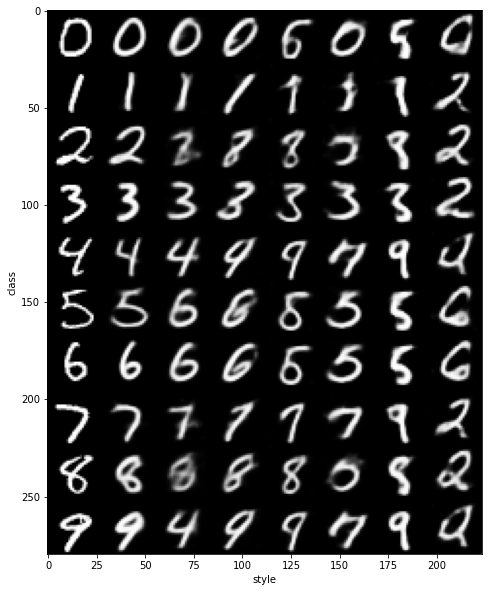

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

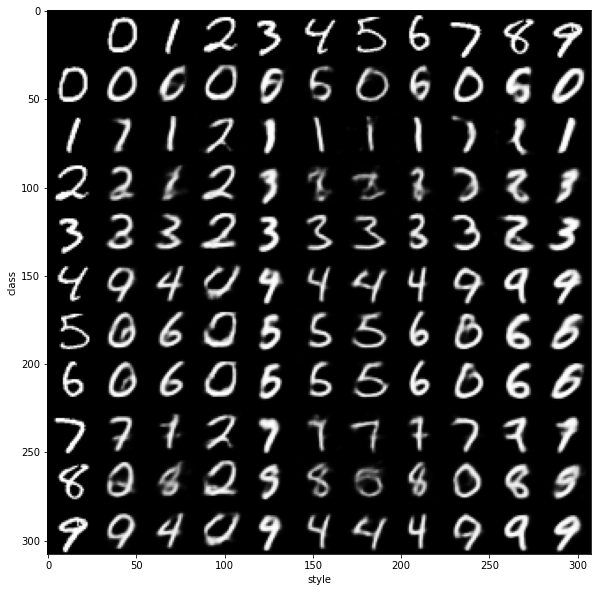

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()